# Market quota game

## Simulating SNP500 data

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import datetime, timedelta
import pandas as pd

In [60]:
pd.date_range(start=datetime.now(), periods=n, freq="10ms")

DatetimeIndex(['2025-09-14 12:12:26.684946', '2025-09-14 12:12:26.694946',
               '2025-09-14 12:12:26.704946', '2025-09-14 12:12:26.714946',
               '2025-09-14 12:12:26.724946', '2025-09-14 12:12:26.734946',
               '2025-09-14 12:12:26.744946', '2025-09-14 12:12:26.754946',
               '2025-09-14 12:12:26.764946', '2025-09-14 12:12:26.774946',
               ...
               '2025-09-14 12:22:26.584946', '2025-09-14 12:22:26.594946',
               '2025-09-14 12:22:26.604946', '2025-09-14 12:22:26.614946',
               '2025-09-14 12:22:26.624946', '2025-09-14 12:22:26.634946',
               '2025-09-14 12:22:26.644946', '2025-09-14 12:22:26.654946',
               '2025-09-14 12:22:26.664946', '2025-09-14 12:22:26.674946'],
              dtype='datetime64[ns]', length=60000, freq='10L')

In [82]:
r = 0.01
s = 0.1474
S0 = 100
m = r - 0.5*s*s
dt = 1/365/24/60/60/100 #10 ms
n = 100*60*1

In [224]:
def geom_brownian_motion(S0, m, s, n, dt):
    logret = np.random.normal(m * dt, s * np.sqrt(dt), size=n)
    ret = np.exp(logret.cumsum(axis=0))
    price = S0*ret
    return price

In [226]:
geom_brownian_motion(S0, m, s, (n, 3), dt).shape

(6000, 3)

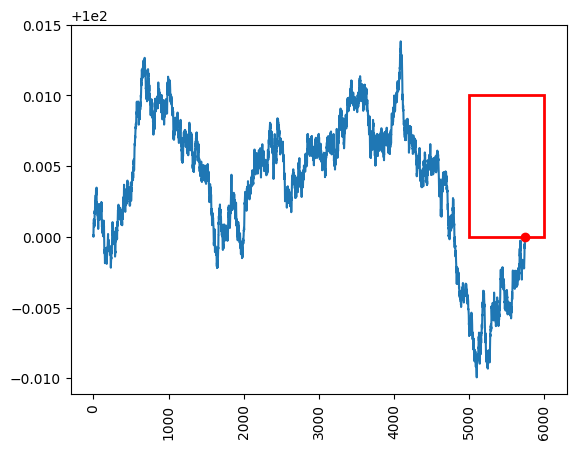

In [228]:
t = np.arange(n)
S = geom_brownian_motion(S0, m, s, n, dt)

fig, ax = plt.subplots()
plt.xticks(rotation=90)
ax.ticklabel_format(style='plain', axis='y')


rect = patches.Rectangle((5000, S0), 1000, 0.01, linewidth=2, edgecolor='r', facecolor='none')

ax.add_patch(rect)

x0, y0, x1, y1 = rect.get_x(), rect.get_y(), rect.get_x() + rect.get_width(), rect.get_y() + rect.get_height()

mask = (t >= x0) & (t <= x1) & (S >= y0) & (S <= y1)


hit = np.any(mask)

if hit:
    points_inside = np.column_stack((t[mask], S[mask]))
    first_x, first_y = points_inside[0]
    ax.scatter(first_x, first_y, color="red", zorder=5, label="First inside point")

    ax.plot(t[:int(first_x)], S[:int(first_x)])
else:
    ax.plot(t, S)
    

plt.show()

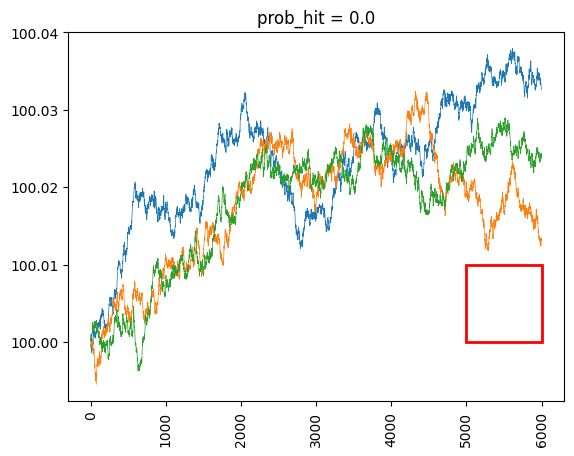

In [288]:
n_paths = 3
show_paths = 20

t = np.arange(n)
S = geom_brownian_motion(S0, m, s, (n, n_paths), dt)

fig, ax = plt.subplots()
plt.xticks(rotation=90)
ax.ticklabel_format(style='plain', axis='y')


rect = patches.Rectangle((5000, S0), 1000, 0.01, linewidth=2, edgecolor='r', facecolor='none')

ax.add_patch(rect)

x0, y0, x1, y1 = rect.get_x(), rect.get_y(), rect.get_x() + rect.get_width(), rect.get_y() + rect.get_height()

hits = 0
for j in range(min(S.shape[1], show_paths)):
    mask = ((t >= x0) & (t <= x1) & (S[:, j] >= y0) & (S[:, j] <= y1))
    
    hit = np.any(mask)
    
    if hit:
        first_idx = np.argmax(mask) 
        first_x, first_y = t[first_idx], S[first_idx, j]
        ax.scatter(first_x, first_y, color="red", zorder=5)
        
        ax.plot(t[:int(first_x)+1], S[:int(first_x)+1, j], linewidth=0.5)
        
        hits += 1
    else:
        ax.plot(t, S[:, j], linewidth=0.5)


prob_hit = hits / n_paths

plt.title(f"{prob_hit = }")
plt.show()

## Fully vectorized version

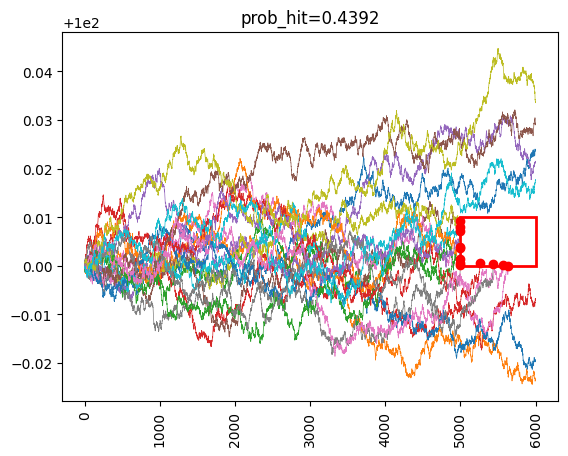

In [ ]:
n_paths = 10000
show_paths = 20

t = np.arange(n)
S = geom_brownian_motion(S0, m, s, (n, n_paths), dt)

t_broadcasted = t[:, None]  # shape (n,1)

mask = (t_broadcasted >= x0) & (t_broadcasted <= x1) & (S >= y0) & (S <= y1)

hits_mask = np.any(mask, axis=0)  # shape (n_paths,), True if path hits

hits_numeric = hits_mask.astype(float)

first_idx = np.argmax(mask, axis=0)  # shape (n_paths,)

first_idx[~hits_mask] = -1

cumsum_hits = np.cumsum(hits_numeric)

cum_prob = cumsum_hits / np.arange(1, len(hits_numeric)+1)

prob_hit = cum_prob[-1]

fig, ax = plt.subplots()
ax.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)

plt.title(f"{prob_hit = }")

rect = patches.Rectangle((5000, S0), 1000, 0.01, linewidth=2, edgecolor='r', facecolor='none')

ax.add_patch(rect)

for j in range(min(S.shape[1], show_paths)):
    if hits_mask[j]:
        idx = first_idx[j]
        ax.plot(t[:idx+1], S[:idx+1, j], linewidth=0.5)
        ax.scatter(t[idx], S[idx, j], color="red", zorder=5)
    else:
        ax.plot(t, S[:, j], linewidth=0.5)

plt.title(f"{prob_hit=}")
plt.show()

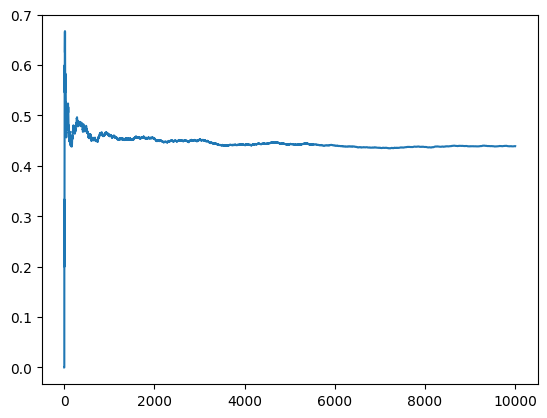

In [323]:
plt.plot(cum_prob)

$4000$ paths should be enough to estimate the probability

## Testing the speed of the simulation

In [328]:
from datetime import datetime

n_paths = 4_000

for _ in range(10):
    t = np.arange(n)
    S = geom_brownian_motion(S0, m, s, (n, n_paths), dt)
    
    start_time = datetime.now()
    t_broadcasted = t[:, None]  # shape (n,1)

    mask = (t_broadcasted >= x0) & (t_broadcasted <= x1) & (S >= y0) & (S <= y1)

    hits_mask = np.any(mask, axis=0)  # shape (n_paths,), True if path hits

    first_idx = np.argmax(mask, axis=0)  # shape (n_paths,)

    first_idx[~hits_mask] = -1

    prob_hit = np.mean(hits_mask)

    duration = datetime.now() - start_time
    print(f"{prob_hit = } calculated in {duration} s")
    
    

prob_hit = 0.4285 calculated in 0:00:00.205536 s
prob_hit = 0.4325 calculated in 0:00:00.243236 s
prob_hit = 0.42775 calculated in 0:00:00.275006 s
prob_hit = 0.443 calculated in 0:00:00.208528 s
prob_hit = 0.4345 calculated in 0:00:00.203665 s
prob_hit = 0.439 calculated in 0:00:00.256089 s
prob_hit = 0.423 calculated in 0:00:00.225039 s
prob_hit = 0.4435 calculated in 0:00:00.222251 s
prob_hit = 0.43375 calculated in 0:00:00.222614 s
prob_hit = 0.4405 calculated in 0:00:00.270605 s


Average time seems to be around 200 ms (too long for real time calculation)